# __Introducción a redes neuronales__
En este parcial asociará el uso común de las redes neuronales con tareas más complejas como el filtrado de imágenes.

# __1. Cargue el conjunto de datos MNIST__

Use KERAS para cargar el conjunto de datos MNIST, adaptelo para una exprimentación adecuada (divida el conjunto de test en dos para obtener la partición de Tune). Una vez cargado añada ruido aleatorio,  a todos los conjuntos.

Muestre un ejemplo para cada una de las etiquetas con y sin ruido (Tómelos del conjunto de entrenamiento).

## __Bibliotecas/Imports__

In [1]:
!pip install -q keras-tuner --upgrade


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.manifold import TSNE
from keras.models import Model

import keras_tuner

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import numpy as np
import matplotlib.pyplot as plt

## __Cargar Conjunto de Datos__

Los datos son imagenes

In [3]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## __Obtener Tune (dividir test)__

In [4]:
tune_images, test_images, tune_labels, test_labels = train_test_split(test_images,
                                                                      test_labels,
                                                                      test_size=0.5,
                                                                      random_state=0)

In [5]:
train_images.shape, test_images.shape, tune_images.shape

((60000, 28, 28), (5000, 28, 28), (5000, 28, 28))

## __Añadir ruido a conjuntos__

In [6]:
def add_noise(images, noise_factor=0.3):
  """
  Recibe conjunto de imagenes y les agrega ruido
  """
  noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)*255
  noisy_images = np.clip(noisy_images, 0., 255.)
  return noisy_images

In [7]:
train_noisy = add_noise(train_images)
tune_noisy = add_noise(tune_images)
test_noisy = add_noise(test_images)

## __Normalizar Imagenes__
En las imagenes en blanco y negro, se usa un valor entre 0 y 255, siendo negro y blanco respectivamente.

En imagenes a color, se usan tres valores distintos (entre 0 y 255), uno por color primario (RGB)

In [8]:
train_noisy.min(), train_noisy.max()

(0.0, 255.0)

In [9]:
def normalize(images):
    normalized_images = images / 255.0
    return normalized_images

### __Con ruido__

In [10]:
train_noisy_norm = normalize(train_noisy)
tune_noisy_norm = normalize(tune_noisy)
test_noisy_norm = normalize(test_noisy)

In [11]:
train_noisy_norm.min(), train_noisy_norm.max()

(0.0, 1.0)

### __Sin ruido (originales)__

In [12]:
train_imgs_norm = normalize(train_images)
tune_imgs_norm = normalize(tune_images)
test_imgs_norm = normalize(test_images)

In [13]:
tune_imgs_norm.min(), tune_imgs_norm.max()

(0.0, 1.0)

## __Aplanar imagenes__

In [14]:
def flatten_images(images):
  flattened_images = images.reshape(images.shape[0], -1)
  return flattened_images

### __COn ruido__

In [15]:
train_noisy_norm_flat = flatten_images(train_noisy_norm)
tune_noisy_norm_flat = flatten_images(tune_noisy_norm)
test_noisy_norm_flat = flatten_images(test_noisy_norm)

In [16]:
train_noisy_norm_flat.shape

(60000, 784)

### __Sin Ruido__

In [17]:
train_imgs_norm_flat = flatten_images(train_imgs_norm)
tune_imgs_norm_flat = flatten_images(tune_imgs_norm)
test_imgs_norm_flat = flatten_images(test_imgs_norm)

In [18]:
train_imgs_norm_flat.shape

(60000, 784)

## __Visualizar CON y SIN ruido__

In [19]:
examples_with_noise = [train_noisy_norm[train_labels == label][0] for label in range(10)]
examples_without_noise = [train_images[train_labels == label][0] for label in range(10)]

In [20]:
def plot_examples(examples, title):
    plt.figure(figsize=(10, 5))
    for i, example in enumerate(examples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(example, cmap='gray')
        plt.title(f'Label: {i}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

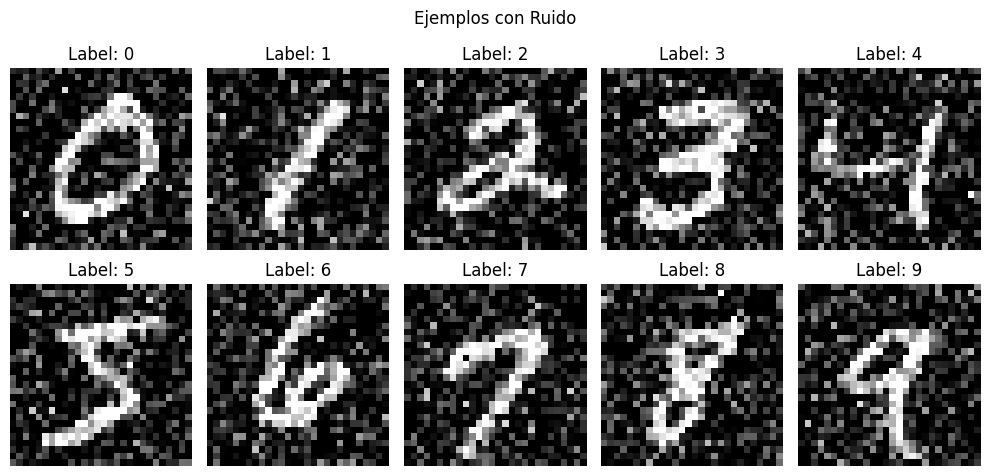

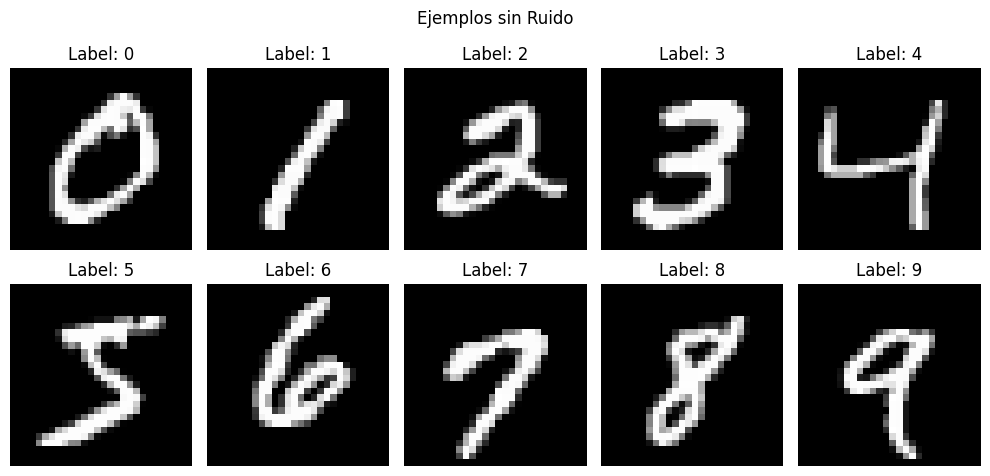

In [21]:
plot_examples(examples_with_noise, 'Ejemplos con Ruido')
plot_examples(examples_without_noise, 'Ejemplos sin Ruido')

# __2. Proponga una estructura neuronal__

En este caso, construirá una red neuronal que sea capaz de limpiar nuestras imágenes. Por lo cual, los conjuntos con ruido serán los datos de entrada y las imágenes limpias la salida. Tomando esto en consideración, proponga una estructura neuronal capaz de realizar dicha tarea.

**Pistas:**


1.   Recuerde aplanar las imágenes usando reshape o una capa de flatten.
2.   Recuerde que la entrada como la salida serán vectores de 784.
3.   La capa intermedia deberá tener menos neuronas que la de entrada y salida.
4.   Piense si esto es una tarea de clasificación o de regresión para que pueda seleccionar adecuadamente la función de coste.
4.   Deberá realizar pruebas para determinar las características de la red neuronas (use keras tuner con almenos 5 experimentos y 3 repeticiones)




## __Estructura Red Neuronal__

* Dado que debe predecir valores para los pixeles, sería una labor de regresión.
* Para regresion, entonces la funcion loss será: MSE

  * __Función de Pérdida (Loss)__: En este caso, la función de pérdida más adecuada es el Error Cuadrático Medio (MSE). Ya que normalmente se usa en problemas de regresión, como es el caso de la eliminación de ruido, donde la salida esperada es una imagen "limpia" y la red neuronal debe aprender a generar una imagen lo más cercana posible a esta.
  
   El MSE calcula la diferencia cuadrática promedio entre los valores predichos y los valores reales, siendo una medida adecuada para evaluar la precisión de la reconstrucción de la imagen.

  * __Métrica de Evaluación:__ Para evaluar la eficacia del modelo en la eliminación de ruido, se usó también el MSE debido a su capacidad para cuantificar la diferencia cuadrática entre las imágenes originales y las reconstruidas, penalizando eficazmente grandes diferencias y brindando una medida coherente y fácil de interpretar de la calidad de la reconstrucción.

  Entre mas alto, peor fue la reconstrucción, por tanto entre mas bajo indica que la reconstrucción fue mejor

  Dado que estan normalizados los valores, lo ideal es que esté lo mas cercano a cero posible.

In [79]:
input_size = train_noisy_norm_flat.shape[1]

def build_model(hp):
    model = keras.Sequential()
    # Capa entrada
    model.add(layers.Dense(units=input_size, activation='relu', input_shape=(input_size,)))
    # Capa Intermedia
    model.add(layers.Dense(units=hp.Int('units_mid',
                                        min_value=64,
                                        max_value=256,
                                        step=32),
                           activation='relu'))
    # Capa Salida
    model.add(layers.Dense(units=input_size, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

variar learning rate, constantes de regularizacion , etc ,etc , es decir mas hiperparmetretros

### __Configurando Tuner__

In [23]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='parcial_1',
    project_name='image_denoising'
)

Reloading Tuner from parcial_1\image_denoising\tuner0.json


In [24]:
tuner.search(train_noisy_norm_flat, train_imgs_norm_flat,
             validation_data=(tune_noisy_norm_flat, tune_imgs_norm_flat),
             epochs=10)

### __Resultados Keras Tuner__

In [25]:
tuner.results_summary()

Results summary
Results in parcial_1\image_denoising
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
units_mid: 224
Score: 0.007352662117530902

Trial 4 summary
Hyperparameters:
units_mid: 192
Score: 0.00747861759737134

Trial 2 summary
Hyperparameters:
units_mid: 128
Score: 0.0077577728467683

Trial 3 summary
Hyperparameters:
units_mid: 96
Score: 0.008261601440608501

Trial 1 summary
Hyperparameters:
units_mid: 64
Score: 0.009857250998417536


In [26]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

c:\Users\manza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\manza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │       175,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       176,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 967,680 (3.69 MB)

 Trainable params: 967,680 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

## __Comprimiendo resultados de los experimentos__

In [27]:
import shutil
import os

folder_path = 'C:/Users/manza/Downloads/parcial_1'
zip_path = 'C:/Users/manza/Downloads/parcial_1'
shutil.make_archive(zip_path, 'zip', folder_path)
print(f'Archivo comprimido listo para descargar: {zip_path}')

Archivo comprimido listo para descargar: C:/Users/manza/Downloads/parcial_1


# __3. Entrena la red neuronal y demuestre su desempeño__

Entre la red neuronal y demuestre el desempeñó. Justifique su elección tanto de función de perdida como de métrica de evaluación. Adicionalmente, muestre los resultados obtenidos para el conjunto de test (recuerde convertir su vector de 784 a una imagen de 28x28).

## __Obteniendo mejor modelo del Tuner__

In [28]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=[keras.metrics.MeanSquaredError()])

### __Early Stopping__

In [29]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               restore_best_weights=True)

### __Model Checkpoints__

In [30]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model_weights.weights.h5', # Added '.weights' to the filename
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min',
                             verbose=1)

## __Entrenando__

In [31]:
best_model.fit(train_noisy_norm_flat, train_imgs_norm_flat,
               validation_data=(test_noisy_norm_flat, test_imgs_norm_flat),
               callbacks=[early_stopping, checkpoint],
               epochs=15)

Epoch 1/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1: val_loss improved from inf to 0.00718, saving model to best_model_weights.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2/15
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 2: val_loss improved from 0.00718 to 0.00711, saving model to best_model_weights.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 3/15
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 3: val_loss improved from 0.00711 to 0.00701, saving model to best_model_weights.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0070 - val_mean_squared_error: 0.0

In [32]:
best_model.save('/content/best_model.h5')

## __Resultados Test__

In [33]:
def vector_to_image(vector):
    return vector.reshape(28, 28)

In [34]:
predictions = best_model.predict(test_noisy_norm_flat)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


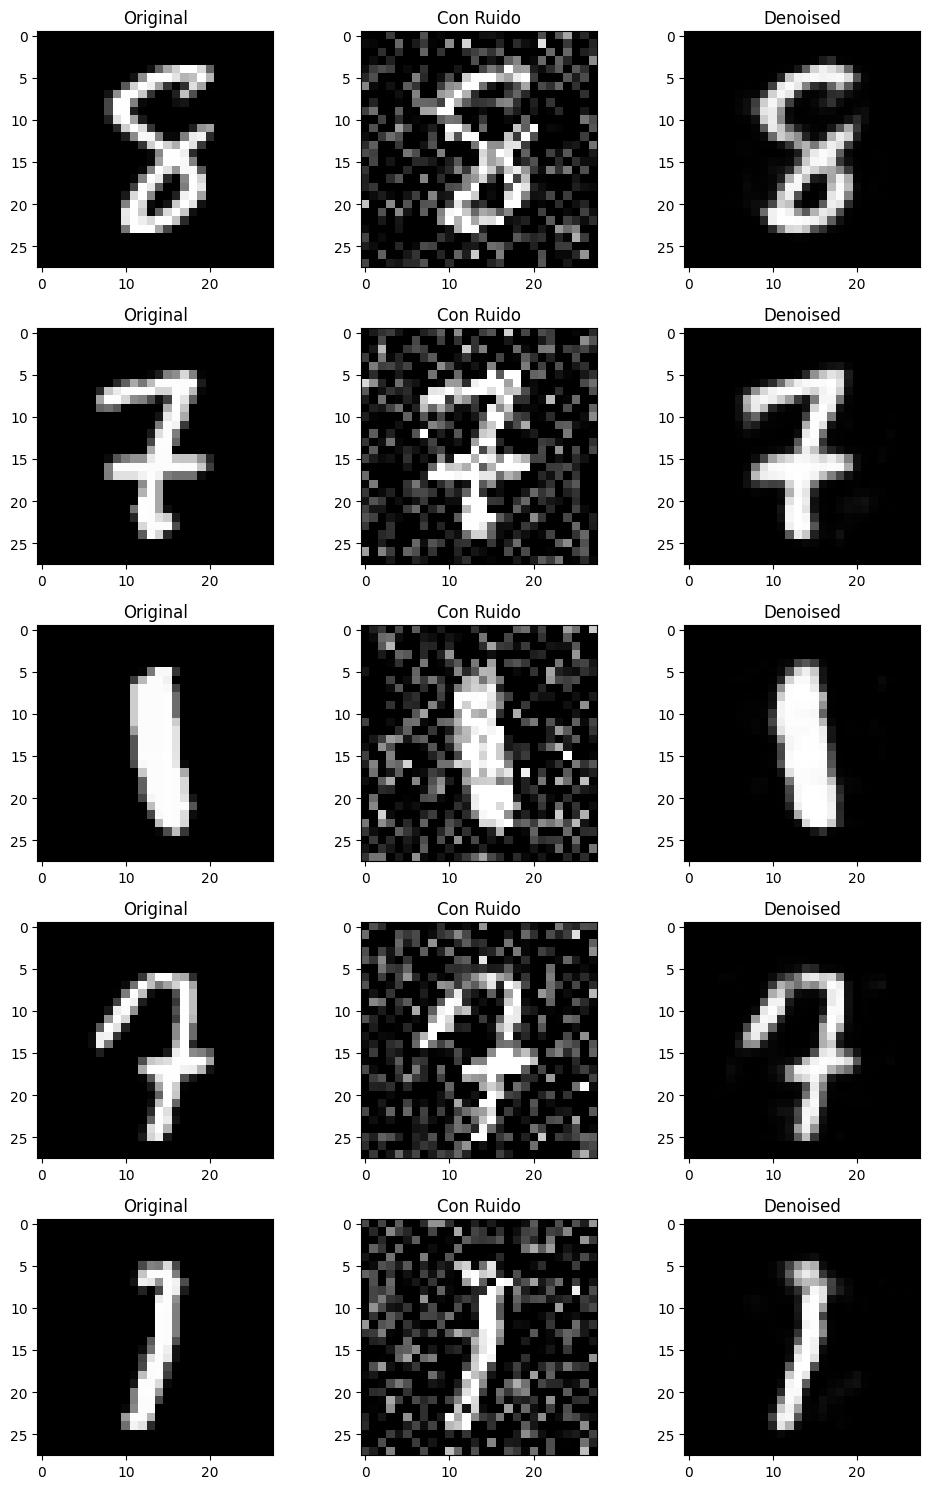

In [35]:
num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(10, 15))

for i in range(num_images_to_show):
    original_image = vector_to_image(test_images[i])
    noisy_image = vector_to_image(test_noisy[i])
    denoised_image = vector_to_image(predictions[i])

    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(noisy_image, cmap='gray')
    axes[i, 1].set_title('Con Ruido')

    axes[i, 2].imshow(denoised_image, cmap='gray')
    axes[i, 2].set_title('Denoised')

plt.tight_layout()
plt.show()

# __4. Extraiga la representación__

Recuerde que la capa intermedia DEBE tener un tamaño menor a las capas de entrada y de salida. Extraiga los valores de dicha capa para cada una de las imágenes. Use una técnica de reducción de dimensionalidad (TSNE ...) y observe un diagrama de dispersión de la representación neuronal etiquetado con cada una de las clases del conjunto de datos.

In [86]:
# Paso 4: Crear un modelo separado para obtener la representación de la capa intermedia
encoder = Model(inputs=input_img, outputs=autoencoder.get_layer('bottleneck').output)

# Extraer las representaciones de la capa intermedia
x_train_encoded = encoder.predict(x_train_noisy)

# Paso 5: Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, random_state=42)
x_train_encoded_2d = tsne.fit_transform(x_train_encoded)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step


In [ ]:
# Paso 6: Visualización del diagrama de dispersión de las representaciones
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_train_encoded_2d[:, 0], x_train_encoded_2d[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE de la Representación Intermedia del Autoencoder')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

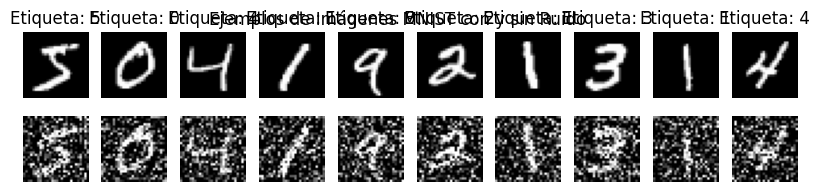

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Cargar el conjunto de datos MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar los valores de los píxeles entre 0 y 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Aplanar las imágenes de 28x28 a 784 (para usar con el autoencoder)
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

# Añadir ruido gaussiano a las imágenes
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Asegurarse de que los valores están entre 0 y 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Mostrar ejemplos de imágenes con y sin ruido para cada etiqueta (tómalo del conjunto de entrenamiento)
plt.figure(figsize=(10, 2))
for i in range(10):
    # Imagen sin ruido
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Etiqueta: {y_train[i]}")
    plt.axis('off')
    
    # Imagen con ruido
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.suptitle('Ejemplos de Imágenes MNIST con y sin Ruido')
plt.show()


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0832 - mean_absolute_error: 0.1836 - val_loss: 0.0391 - val_mean_absolute_error: 0.0984
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0373 - mean_absolute_error: 0.0942 - val_loss: 0.0319 - val_mean_absolute_error: 0.0828
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0313 - mean_absolute_error: 0.0815 - val_loss: 0.0283 - val_mean_absolute_error: 0.0752
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0280 - mean_absolute_error: 0.0746 - val_loss: 0.0260 - val_mean_absolute_error: 0.0706
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - mean_absolute_error: 0.0701 - val_loss: 0.0245 - val_mean_absolute_error: 0.0668
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0245 - mean_absolute_error: 0.0671 - val_loss: 0.0236 - val_mean_absolute_error: 0.0647
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0237 - mean_absolute_error: 0.0651 - v

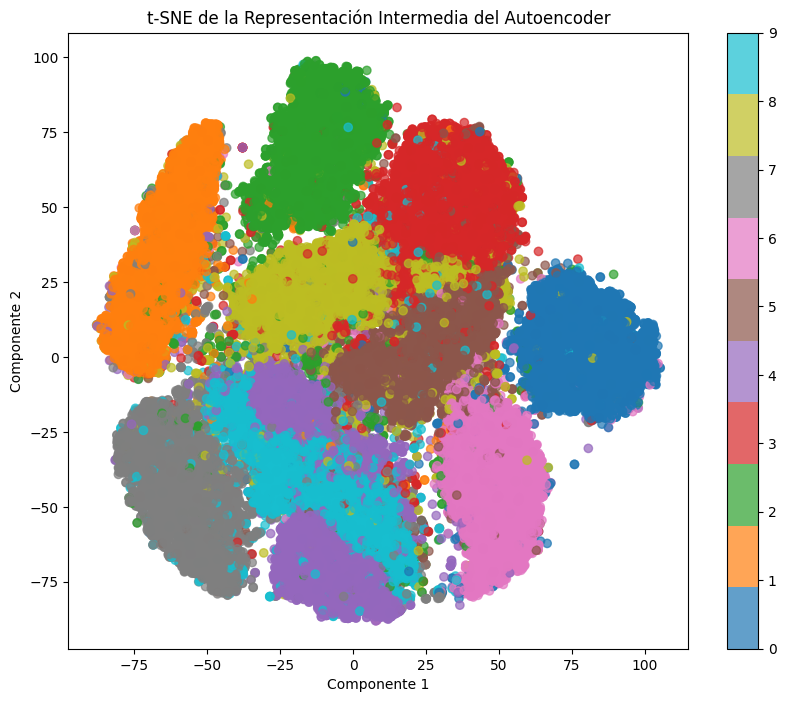

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.manifold import TSNE

# Paso 2: Definir la arquitectura del autoencoder usando la API funcional
input_img = Input(shape=(784,))  # Capa de entrada

# Codificador (encoder)
encoded = Dense(64, activation='relu')(input_img)  # Primera capa oculta
bottleneck = Dense(32, activation='relu', name='bottleneck')(encoded)  # Capa intermedia

# Decodificador (decoder)
decoded = Dense(784, activation='sigmoid')(bottleneck)  # Capa de salida

# Definir el autoencoder completo
autoencoder = Model(inputs=input_img, outputs=decoded)

# Compilación del modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Paso 3: Entrenar el autoencoder
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))

# Paso 4: Crear un modelo separado para obtener la representación de la capa intermedia
encoder = Model(inputs=input_img, outputs=autoencoder.get_layer('bottleneck').output)

# Extraer las representaciones de la capa intermedia
x_train_encoded = encoder.predict(x_train_noisy)

# Paso 5: Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, random_state=42)
x_train_encoded_2d = tsne.fit_transform(x_train_encoded)

# Paso 6: Visualización del diagrama de dispersión de las representaciones
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_train_encoded_2d[:, 0], x_train_encoded_2d[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE de la Representación Intermedia del Autoencoder')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()